# BERT on Sensitag
Use BERT on 2 datasets:
1. agreement of at least 2 annotators;
2. agreement of 3 annotators.

Test the model also on the 10 samples of twitter-whisperer dataset


## Set the variables

In [1]:
# directories
main_path = "/content/drive/MyDrive/Colab Notebooks/"
data_path = main_path+"data/"
results_path = main_path+"results/"
models_path = main_path+"models/"
dataset_our_filename = "annotation_results__ann"
dataset_wt_filename = "sample_ann2_"

# classes
Y_feat_names = ["ns", "sens"]

## Import libraries

In [ ]:
# install ktrain on Google Colab
!pip3 install ktrain

## for explaination
#!pip3 install git+https://github.com/amaiya/eli5@tfkeras_0_10_1

In [3]:
# mount Google drive
from google.colab import drive
drive.mount('/content/drive')

# import modules in local directory
import sys
sys.path.append(main_path+'/lib')

Mounted at /content/drive


In [5]:
# import ktrain and the ktrain.text modules
import ktrain
from ktrain import text

import pandas as pd
#from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#from utils import get_data, get_two_classes, my_train_val_test_split, plot_confusion_matrix_from_cmat, predict_class_BERT
from utils import get_data, get_two_classes, plot_confusion_matrix_from_cmat, predict_class_BERT

from sklearn import metrics

def get_metrics(y_test, y_pred, Y_feat_names):
    res = {}
    res["accuracy"] = metrics.accuracy_score(y_test, y_pred)
    tmp = metrics.precision_score(y_test, y_pred, average=None)
    for index, cls in enumerate(Y_feat_names):
        res["precision_"+cls] = tmp[index]
    tmp = metrics.recall_score(y_test, y_pred, average=None)
    for index, cls in enumerate(Y_feat_names):
        res["recall_"+cls] = tmp[index]
    tmp = metrics.f1_score(y_test, y_pred, average=None)
    for index, cls in enumerate(Y_feat_names):
        res["f1_"+cls] = tmp[index]
    res["f1-micro"] = metrics.f1_score(y_test, y_pred, average="micro")
    res["f1-macro"] = metrics.f1_score(y_test, y_pred, average="macro")
    return res

def predict_class_BERT_2(text, predictor, Y_feat_names, real_class=None):
    result_pred = predictor.predict_proba(text)
    result_feat = Y_feat_names[0]
    if result_pred[1] > result_pred[0]:
        result_feat = Y_feat_names[1]
    return result_feat

# **Agreement on 2 annotators**
## STEP 1: Get train and test sets 

In [ ]:
ann = 2
# get data
train_loc = pd.read_csv(data_path+dataset_our_filename+str(ann)+"_training.csv")
val_loc = pd.read_csv(data_path+dataset_our_filename+str(ann)+"_validation.csv")
test_loc = pd.read_csv(data_path+dataset_our_filename+str(ann)+"_test.csv")
# transform data into sets for models
x_train = train_loc["text"].tolist()
y_train = pd.get_dummies(pd.DataFrame({"class": train_loc["class"].tolist()})["class"])[Y_feat_names].values
x_val = val_loc["text"].tolist()
y_val = pd.get_dummies(pd.DataFrame({"class": val_loc["class"].tolist()})["class"])[Y_feat_names].values
x_test = test_loc["text"].tolist()
y_test = pd.get_dummies(pd.DataFrame({"class": test_loc["class"].tolist()})["class"])[Y_feat_names].values


In [ ]:
x_train[0]

'was worried when she saw the new facebook layout page until she figured out how to get to Tetris! She is ridiculously addicted to that game! :P'

In [ ]:
y_train[0]

array([0, 1], dtype=uint8)

## STEP 2: Load and Preprocess the Data


In [ ]:
(x_train_bert,  y_train_bert), (x_val_bert, y_val_bert), preproc = text.texts_from_array(x_train=x_train, y_train=y_train,
                                                                                          x_test=x_val, y_test=y_val,
                                                                                          class_names=Y_feat_names,
                                                                                          preprocess_mode='bert',
                                                                                          lang='en',
                                                                                          maxlen=350, 
                                                                                          max_features=35000)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


## STEP 3:  Load the BERT Model and Instantiate a Learner object


In [ ]:
model = text.text_classifier('bert', train_data=(x_train_bert, y_train_bert), preproc=preproc)
learner = ktrain.get_learner(model, train_data=(x_train_bert, y_train_bert), val_data=(x_val_bert, y_val_bert), batch_size=6)


Is Multi-Label? False
maxlen is 350
done.


## STEP 4: Train the Model


In [ ]:
learner.autofit(5e-5)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/1024
1096/1096 [==============================] - 1375s 1s/step - loss: 0.5540 - accuracy: 0.7229 - val_loss: 0.4302 - val_accuracy: 0.7968
Epoch 2/1024
1096/1096 [==============================] - 1358s 1s/step - loss: 0.3187 - accuracy: 0.8689 - val_loss: 0.4596 - val_accuracy: 0.7998
Epoch 3/1024
1096/1096 [==============================] - 1361s 1s/step - loss: 0.1677 - accuracy: 0.9398 - val_loss: 0.5489 - val_accuracy: 0.8044

Epoch 00003: Reducing Max LR on Plateau: new max lr will be 2.5e-05 (if not early_stopping).
Epoch 4/1024
1096/1096 [==============================] - 1360s 1s/step - loss: 0.0618 - accuracy: 0.9803 - val_loss: 0.7198 - val_accuracy: 0.8037
Epoch 5/1024
1096/1096 [==============================] - 1360s 1s/step - loss: 0.0380 - accuracy: 0.9885 - val_loss: 0.8861 - val

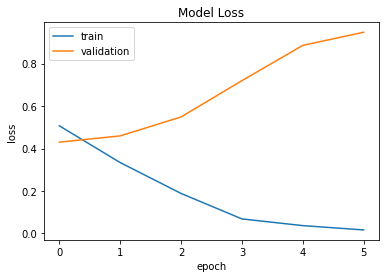

In [ ]:
learner.plot()

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       814
           1       0.73      0.73      0.73       500

    accuracy                           0.80      1314
   macro avg       0.78      0.78      0.78      1314
weighted avg       0.80      0.80      0.80      1314



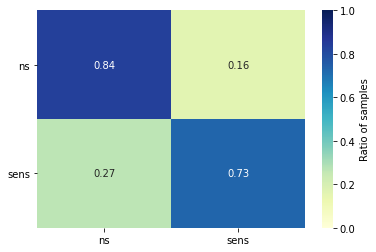

In [ ]:
df_val = learner.evaluate()
plot_confusion_matrix_from_cmat(df_val, normalize=True, labels=Y_feat_names)


In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)
# save
predictor.save(models_path+"sensitag_BERT_ann2")


## STEP 5: Test the Model


              precision    recall  f1-score   support

          ns       0.83      0.83      0.83       543
        sens       0.73      0.73      0.73       333

    accuracy                           0.79       876
   macro avg       0.78      0.78      0.78       876
weighted avg       0.79      0.79      0.79       876



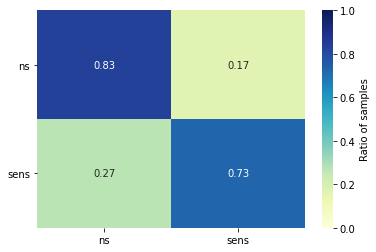

In [ ]:
# validation on test set
x_test_bert = preproc.preprocess(x_test)
df_test = learner.validate(val_data=(x_test_bert, y_test), class_names=Y_feat_names)
plot_confusion_matrix_from_cmat(df_test, normalize=True, labels=Y_feat_names)


In [ ]:
from sklearn import metrics

def get_metrics(y_test, y_pred, Y_feat_names):
    res = {}
    res["accuracy"] = metrics.accuracy_score(y_test, y_pred)
    tmp = metrics.precision_score(y_test, y_pred, average=None)
    for index, cls in enumerate(Y_feat_names):
        res["precision_"+cls] = tmp[index]
    tmp = metrics.recall_score(y_test, y_pred, average=None)
    for index, cls in enumerate(Y_feat_names):
        res["recall_"+cls] = tmp[index]
    tmp = metrics.f1_score(y_test, y_pred, average=None)
    for index, cls in enumerate(Y_feat_names):
        res["f1_"+cls] = tmp[index]
    res["f1-micro"] = metrics.f1_score(y_test, y_pred, average="micro")
    res["f1-macro"] = metrics.f1_score(y_test, y_pred, average="macro")
    return res

def predict_class_BERT_2(text, predictor, Y_feat_names, real_class=None):
    result_pred = predictor.predict_proba(text)
    result_feat = Y_feat_names[0]
    if result_pred[1] > result_pred[0]:
        result_feat = Y_feat_names[1]
    return result_feat

met_dict = []

y_test_feat = [Y_feat_names[0] if x[0] == 1 else Y_feat_names[1] for x in y_test]
y_pred_feat = [predict_class_BERT_2(x, predictor, Y_feat_names) for x in x_test]
met_dict_loc = get_metrics(y_test_feat, y_pred_feat, Y_feat_names)
met_dict_loc["set"] = "test"
met_dict_loc["ann"] = ann
met_dict.append(met_dict_loc)
pd.DataFrame(met_dict)

,accuracy,precision_ns,precision_sens,recall_ns,recall_sens,f1_ns,f1_sens,f1-micro,f1-macro,set,ann
0,0.793379,0.833948,0.727545,0.832413,0.72973,0.83318,0.728636,0.793379,0.780908,test,2


## STEP : Test the Model on other datasets


In [ ]:
for index in range(10):
    test_loc = pd.read_csv(data_path+dataset_wt_filename+(("0"+str(index+1))[-2:])+".csv")
    x_test_loc = test_loc["text"].tolist()
    y_test_feat = test_loc["class"].tolist()
    #y_test_feat = [Y_feat_names[0] if x[0] == 1 else Y_feat_names[1] for x in y_test_loc]
    y_pred_feat = [predict_class_BERT_2(x, predictor, Y_feat_names) for x in x_test_loc]
    met_dict_loc = get_metrics(y_test_feat, y_pred_feat, Y_feat_names)
    met_dict_loc["set"] = str(index+1)
    met_dict_loc["ann"] = ann
    #print(met_dict_loc)
    met_dict.append(met_dict_loc)
pd.DataFrame(met_dict)

,accuracy,precision_ns,precision_sens,recall_ns,recall_sens,f1_ns,f1_sens,f1-micro,f1-macro,set,ann
0,0.793379,0.833948,0.727545,0.832413,0.729730,0.833180,0.728636,0.793379,0.780908,test,2
1,0.631147,0.672587,0.521432,0.788175,0.375600,0.725808,0.436661,0.631147,0.581235,1,2
2,0.621563,0.667036,0.503889,0.776754,0.369005,0.717726,0.426025,0.621563,0.571876,2,2
3,0.629093,0.674352,0.516872,0.775833,0.390288,0.721542,0.444748,0.629093,0.583145,3,2
4,0.632288,0.676254,0.522537,0.779517,0.392686,0.724223,0.448400,0.632288,0.586312,4,2
5,0.624986,0.671635,0.509703,0.771965,0.385791,0.718313,0.439174,0.624986,0.578744,5,2
6,0.633771,0.675028,0.525969,0.788175,0.382494,0.727226,0.442902,0.633771,0.585064,6,2
7,0.626469,0.670464,0.512684,0.780623,0.375600,0.721362,0.433564,0.626469,0.577463,7,2
8,0.624643,0.670167,0.509274,0.775833,0.378597,0.719139,0.434319,0.624643,0.576729,8,2
9,0.635254,0.675859,0.528731,0.790017,0.383393,0.728493,0.444483,0.635254,0.586488,9,2


In [ ]:
# reload the predictor
ann = 2
predictor = ktrain.load_predictor(models_path+"sensitag_BERT_ann"+str(ann))

In [ ]:
other_ann = 3

# get data
data_loc = get_data(data_path+"annotation_results.csv", lim=other_ann)
data_loc = get_two_classes(data_loc)
x_test_loc = data_loc["text"].tolist()
y_test_feat = data_loc["class"].tolist()
y_pred_feat = [predict_class_BERT_2(x, predictor, Y_feat_names) for x in x_test_loc]
met_dict_loc = get_metrics(y_test_feat, y_pred_feat, Y_feat_names)
met_dict_loc["set"] = "ann"+str(other_ann)
met_dict_loc["ann"] = ann
#met_dict.append(met_dict_loc)
#pd.DataFrame(met_dict)
pd.DataFrame([met_dict_loc])

ValueError: ignored

In [ ]:
pd.DataFrame([met_dict_loc])

,accuracy,precision_ns,precision_sens,recall_ns,recall_sens,f1_ns,f1_sens,f1-micro,f1-macro,set,ann
0,0.943648,0.962588,0.910811,0.94927,0.933518,0.955882,0.922025,0.943648,0.938953,ann3,2


# **Agreement on 3 annotators**
## STEP 1: Get train and test sets 

In [ ]:
ann = 3
# get data
train_loc = pd.read_csv(data_path+dataset_our_filename+str(ann)+"_training.csv")
val_loc = pd.read_csv(data_path+dataset_our_filename+str(ann)+"_validation.csv")
test_loc = pd.read_csv(data_path+dataset_our_filename+str(ann)+"_test.csv")
# transform data into sets for models
x_train = train_loc["text"].tolist()
y_train = pd.get_dummies(pd.DataFrame({"class": train_loc["class"].tolist()})["class"])[Y_feat_names].values
x_val = val_loc["text"].tolist()
y_val = pd.get_dummies(pd.DataFrame({"class": val_loc["class"].tolist()})["class"])[Y_feat_names].values
x_test = test_loc["text"].tolist()
y_test = pd.get_dummies(pd.DataFrame({"class": test_loc["class"].tolist()})["class"])[Y_feat_names].values


In [ ]:
x_train[0]

"Once again can't sleep, but too tired to do anything productive."

In [ ]:
y_train[0]

array([0, 1], dtype=uint8)

## STEP 2: Load and Preprocess the Data


In [ ]:
(x_train_bert,  y_train_bert), (x_val_bert, y_val_bert), preproc = text.texts_from_array(x_train=x_train, y_train=y_train,
                                                                                          x_test=x_val, y_test=y_val,
                                                                                          class_names=Y_feat_names,
                                                                                          preprocess_mode='bert',
                                                                                          lang='en',
                                                                                          maxlen=350, 
                                                                                          max_features=35000)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


## STEP 3:  Load the BERT Model and Instantiate a Learner object


In [ ]:
model = text.text_classifier('bert', train_data=(x_train_bert, y_train_bert), preproc=preproc)
learner = ktrain.get_learner(model, train_data=(x_train_bert, y_train_bert), val_data=(x_val_bert, y_val_bert), batch_size=6)


Is Multi-Label? False
maxlen is 350
done.


## STEP 4: Train the Model


In [ ]:
learner.autofit(5e-5)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/1024
506/506 [==============================] - 398s 757ms/step - loss: 0.4617 - accuracy: 0.7641 - val_loss: 0.2024 - val_accuracy: 0.9175
Epoch 2/1024
506/506 [==============================] - 382s 754ms/step - loss: 0.1148 - accuracy: 0.9629 - val_loss: 0.1938 - val_accuracy: 0.9208
Epoch 3/1024
506/506 [==============================] - 383s 758ms/step - loss: 0.0499 - accuracy: 0.9862 - val_loss: 0.2333 - val_accuracy: 0.9158
Epoch 4/1024
506/506 [==============================] - 380s 751ms/step - loss: 0.0395 - accuracy: 0.9877 - val_loss: 0.2867 - val_accuracy: 0.9224

Epoch 00004: Reducing Max LR on Plateau: new max lr will be 2.5e-05 (if not early_stopping).
Epoch 5/1024
506/506 [==============================] - 377s 746ms/step - loss: 0.0099 - accuracy: 0.9960 - val_loss: 0.3528 - val

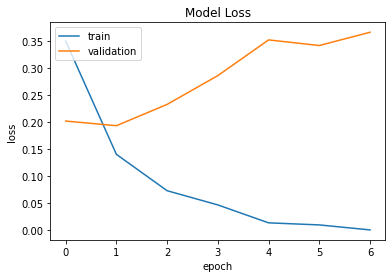

In [ ]:
learner.plot()

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       390
           1       0.87      0.92      0.89       216

    accuracy                           0.92       606
   macro avg       0.91      0.92      0.91       606
weighted avg       0.92      0.92      0.92       606



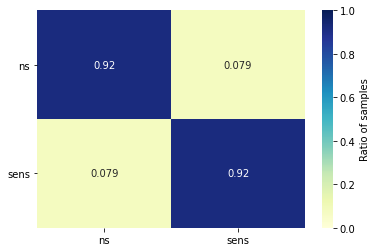

In [ ]:
df_val = learner.evaluate()
plot_confusion_matrix_from_cmat(df_val, normalize=True, labels=Y_feat_names)


In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)
# save
predictor.save(models_path+"sensitag_BERT_ann"+str(ann))


## STEP 5: Test the Model


              precision    recall  f1-score   support

          ns       0.92      0.92      0.92       260
        sens       0.85      0.85      0.85       144

    accuracy                           0.90       404
   macro avg       0.89      0.89      0.89       404
weighted avg       0.90      0.90      0.90       404



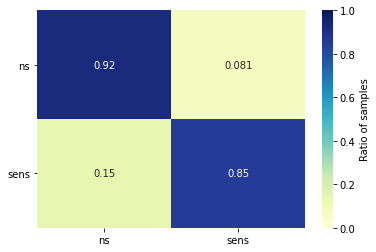

In [ ]:
# validation on test set
x_test_bert = preproc.preprocess(x_test)
df_test = learner.validate(val_data=(x_test_bert, y_test), class_names=Y_feat_names)
plot_confusion_matrix_from_cmat(df_test, normalize=True, labels=Y_feat_names)


In [ ]:
met_dict = []

y_test_feat = [Y_feat_names[0] if x[0] == 1 else Y_feat_names[1] for x in y_test]
y_pred_feat = [predict_class_BERT_2(x, predictor, Y_feat_names) for x in x_test]
met_dict_loc = get_metrics(y_test_feat, y_pred_feat, Y_feat_names)
met_dict_loc["set"] = "test"
met_dict_loc["ann"] = ann
met_dict.append(met_dict_loc)
pd.DataFrame(met_dict)


,accuracy,precision_ns,precision_sens,recall_ns,recall_sens,f1_ns,f1_sens,f1-micro,f1-macro,set,ann
0,0.89604,0.919231,0.854167,0.919231,0.854167,0.919231,0.854167,0.89604,0.886699,test,3


## STEP : Test the Model on other datasets


In [ ]:
# reload the predictor
ann = 3
predictor = ktrain.load_predictor(models_path+"sensitag_BERT_ann"+str(ann))

In [ ]:
met_dict = []

y_test_feat = [Y_feat_names[0] if x[0] == 1 else Y_feat_names[1] for x in y_test]
y_pred_feat = [predict_class_BERT_2(x, predictor, Y_feat_names) for x in x_test]
met_dict_loc = get_metrics(y_test_feat, y_pred_feat, Y_feat_names)
met_dict_loc["set"] = "test"
met_dict_loc["ann"] = ann
met_dict.append(met_dict_loc)
pd.DataFrame(met_dict)

,accuracy,precision_ns,precision_sens,recall_ns,recall_sens,f1_ns,f1_sens,f1-micro,f1-macro,set,ann
0,0.89604,0.919231,0.854167,0.919231,0.854167,0.919231,0.854167,0.89604,0.886699,test,3


In [ ]:
for index in range(10):
    print("sample", (index+1))
    test_loc = pd.read_csv(data_path+dataset_wt_filename+(("0"+str(index+1))[-2:])+".csv")
    x_test_loc = test_loc["text"].tolist()
    y_test_feat = test_loc["class"].tolist()
    #y_test_feat = [Y_feat_names[0] if x[0] == 1 else Y_feat_names[1] for x in y_test_loc]
    y_pred_feat = [predict_class_BERT_2(x, predictor, Y_feat_names) for x in x_test_loc]
    met_dict_loc = get_metrics(y_test_feat, y_pred_feat, Y_feat_names)
    met_dict_loc["set"] = str(index+1)
    met_dict_loc["ann"] = ann
    #print(met_dict_loc)
    met_dict.append(met_dict_loc)
pd.DataFrame(met_dict)

sample 1
sample 2
sample 3
sample 4
sample 5
sample 6
sample 7
sample 8
sample 9
sample 10


,accuracy,precision_ns,precision_sens,recall_ns,recall_sens,f1_ns,f1_sens,f1-micro,f1-macro,set,ann
0,0.896040,0.919231,0.854167,0.919231,0.854167,0.919231,0.854167,0.896040,0.886699,test,3
1,0.583001,0.632586,0.423133,0.779517,0.263189,0.698407,0.324524,0.583001,0.511466,1,3
2,0.583001,0.634353,0.426260,0.771413,0.276379,0.696201,0.335334,0.583001,0.515768,2,3
3,0.578209,0.629952,0.414089,0.773255,0.260791,0.694286,0.320029,0.578209,0.507158,3,3
4,0.585625,0.635418,0.430516,0.776570,0.274880,0.698939,0.335529,0.585625,0.517234,4,3
5,0.576726,0.630961,0.415077,0.762756,0.273981,0.690627,0.330083,0.576726,0.510355,5,3
6,0.582886,0.632690,0.423225,0.778596,0.264388,0.698101,0.325461,0.582886,0.511781,6,3
7,0.575699,0.628301,0.408853,0.771229,0.257494,0.692467,0.315983,0.575699,0.504225,7,3
8,0.577981,0.629530,0.413033,0.774360,0.258393,0.694474,0.317905,0.577981,0.506190,8,3
9,0.586994,0.635872,0.432638,0.779702,0.273381,0.700480,0.335048,0.586994,0.517764,9,3


In [ ]:
pd.DataFrame(met_dict).to_csv(results_path+"00 - Sensitag-BERT - our/ann3.csv")

In [ ]:
# reload the predictor
ann = 3
predictor = ktrain.load_predictor(models_path+"sensitag_BERT_ann"+str(ann))

In [ ]:
other_ann = 2

# get data
data_loc = get_data(data_path+"annotation_results.csv", lim=other_ann)
data_loc = get_two_classes(data_loc)
x_test_loc = data_loc["text"].tolist()
y_test_feat = data_loc["class"].tolist()
y_pred_feat = [predict_class_BERT_2(x, predictor, Y_feat_names) for x in x_test_loc]
met_dict_loc = get_metrics(y_test_feat, y_pred_feat, Y_feat_names)
met_dict_loc["set"] = "ann"+str(other_ann)
met_dict_loc["ann"] = ann
#met_dict.append(met_dict_loc)
#pd.DataFrame(met_dict)
pd.DataFrame([met_dict_loc])

,accuracy,precision_ns,precision_sens,recall_ns,recall_sens,f1_ns,f1_sens,f1-micro,f1-macro,set,ann
0,0.8251,0.849354,0.78269,0.872352,0.748201,0.8607,0.765057,0.8251,0.812879,ann2,3


## Co-occurrences on mini test

In [9]:
ann = 2
other_ann = 3
Y_feat_names = ["ns", "sens"]

# reload the predictor
predictor = ktrain.load_predictor(models_path+"sensitag_BERT_ann"+str(ann))
# get data
test_loc_2 = pd.read_csv(data_path+dataset_our_filename+str(other_ann)+"_test-notrains"+str(ann)+".csv")
x_test_loc = test_loc_2["text"].tolist()
y_test_feat = test_loc_2["class"].tolist()
y_pred_feat = [predict_class_BERT_2(x, predictor, Y_feat_names) for x in x_test_loc]
met_dict_loc = get_metrics(y_test_feat, y_pred_feat, Y_feat_names)
met_dict_loc["set"] = "ann"+str(other_ann)
met_dict_loc["ann"] = ann
#met_dict.append(met_dict_loc)
#pd.DataFrame(met_dict)
pd.DataFrame([met_dict_loc])

,accuracy,precision_ns,precision_sens,recall_ns,recall_sens,f1_ns,f1_sens,f1-micro,f1-macro,set,ann
0,0.944444,0.944444,0.944444,0.971429,0.894737,0.957746,0.918919,0.944444,0.938333,ann3,2


In [10]:
ann = 3
other_ann = 2
Y_feat_names = ["ns", "sens"]

# reload the predictor
predictor = ktrain.load_predictor(models_path+"sensitag_BERT_ann"+str(ann))
# get data
test_loc_2 = pd.read_csv(data_path+dataset_our_filename+str(other_ann)+"_test-notrains"+str(ann)+".csv")
x_test_loc = test_loc_2["text"].tolist()
y_test_feat = test_loc_2["class"].tolist()
y_pred_feat = [predict_class_BERT_2(x, predictor, Y_feat_names) for x in x_test_loc]
met_dict_loc = get_metrics(y_test_feat, y_pred_feat, Y_feat_names)
met_dict_loc["set"] = "ann"+str(other_ann)
met_dict_loc["ann"] = ann
#met_dict.append(met_dict_loc)
#pd.DataFrame(met_dict)
pd.DataFrame([met_dict_loc])

,accuracy,precision_ns,precision_sens,recall_ns,recall_sens,f1_ns,f1_sens,f1-micro,f1-macro,set,ann
0,0.737882,0.783333,0.654822,0.805714,0.623188,0.794366,0.638614,0.737882,0.71649,ann2,3


## STEP 7: Use the Model

In [ ]:
# use the trained model on simple sentences
for input_text in ["is happy", "is tired", "is depressed", "is back from Spain", "is in Spain", "loves Spain",
                   "is in Italy", "loves Italy", "is going out", "is out", "works until 6PM", "starts working at 9AM"]:
    predict_class(input_text, predictor, Y_feat_names)


is happy -> ns (ns: 0.7771542 sens: 0.22284576)
is tired -> sens (ns: 0.16433205 sens: 0.83566797)
is depressed -> sens (ns: 0.14336483 sens: 0.8566352)
is back from Spain -> sens (ns: 0.0730244 sens: 0.92697555)
is in Spain -> sens (ns: 0.06472975 sens: 0.93527025)
loves Spain -> ns (ns: 0.61985654 sens: 0.3801435)
is in Italy -> sens (ns: 0.06274815 sens: 0.9372518)
loves Italy -> ns (ns: 0.52480716 sens: 0.47519287)
is going out -> sens (ns: 0.1119012 sens: 0.8880988)
is out -> sens (ns: 0.3319147 sens: 0.66808534)
works until 6PM -> sens (ns: 0.10200626 sens: 0.8979938)
starts working at 9AM -> sens (ns: 0.10932399 sens: 0.89067596)


In [ ]:
# use the trained model on few sentences in the test set
for index, input_text in enumerate(x_test[:10]):
    real_class = [y for x,y in zip(y_test[index],Y_feat_names) if x==1][0]
    predict_class(input_text, predictor, Y_feat_names, real_class=real_class)

People need to take a breather and chill once in a while and not let the little nuisances of life get to their heads... we only have one life and there is not point to wasting it being angry about nothing... -> ns (V) (ns: 0.85657513 sens: 0.14342491)[ns]
so happy! dum duh duh DA dadadada dm dm dm dm -> ns (V) (ns: 0.6701126 sens: 0.32988742)[ns]
hungers and thirsts for righteousness. -> ns (V) (ns: 0.90058434 sens: 0.09941566)[ns]
perseverance is more than endurance. it is endurance combined with absolute assurance and ceainty that what we are looking for is going to happen -> ns (V) (ns: 0.90103626 sens: 0.098963715)[ns]
just got tickets to the phish show at shoreline! -> sens (V) (ns: 0.09358812 sens: 0.9064119)[sens]
Classes sta 1//26 at 1:30 pm. I'm so excited! -> sens (V) (ns: 0.10547879 sens: 0.89452124)[sens]
Let's see how many people on fb aren't ashamed to show their love for God and admit that Jesus is their Savior... We need to get God back in America... If you're not asham

In [ ]:
# try the explaination tool of the trained model on a sentence in the test set
test_index = 1
print(x_test[test_index])
print(Y_feat_names, y_test[test_index])
predictor.explain(x_test[test_index])

so happy! dum duh duh DA dadadada dm dm dm dm
['ns', 'sens'] [1 0]


In [ ]:
# get the set of uncertain sentences
data_uncertain = get_data(dataset_path)
data_uncertain = data_uncertain[data_uncertain["class"] == "Non so"]["text"].values
len(data_uncertain)

190

In [ ]:
# use the trained model on few sentences in the set of uncertain sentences
for input_text in data_uncertain[:20]:
    predict_class(input_text, predictor, Y_feat_names)


www.thejokerblogs.com -> ns (ns: 0.9370423 sens: 0.06295764)
is in love with *PROPNAME*. -> sens (ns: 0.28448573 sens: 0.7155143)
is in love. With *PROPNAME*. -> sens (ns: 0.27982295 sens: 0.72017705)
is dying!!! HEEEEELPPPPP!!!!! -> sens (ns: 0.22434884 sens: 0.77565116)
WOW!!! I just spent 20 minutes reading just this one strip... [link] -> ns (ns: 0.7398471 sens: 0.26015288)
acquired 6 brothers and sisters today... -> ns (ns: 0.5386914 sens: 0.4613086)
is trying to fight it off -> ns (ns: 0.8703664 sens: 0.1296336)
is still patiently waiting for 9 -> ns (ns: 0.75923836 sens: 0.24076164)
HOLY. FUCK. [link] -> ns (ns: 0.9144462 sens: 0.08555385)
thanks everyone, but i decided to get younger this year... :) -> sens (ns: 0.4980275 sens: 0.5019725)
bar... -> ns (ns: 0.5518921 sens: 0.44810784)
thinks it's funny that only his white best friend remembered *PROPNAME*. -> ns (ns: 0.90488327 sens: 0.09511678)
has heard *PROPNAME*'s tragic call to keep my shit together and live life properly. 

## STEP 8: Load and reuse the Model


In [ ]:
# reload the predictor
predictor = ktrain.load_predictor("/content/drive/MyDrive/Colab Notebooks/results/sensitag_BERT_ann2")
# make a prediction on the same document to verify it still works
# predictor.predict(x_test[0])


In [ ]:
data_test = pd.read_csv(main_path+"data/sample_ann2_01.csv").dropna()
print('DataSet:\n', data_test.head())


DataSet:
                                                 text class
0  Column's all done for another week. Shaheen Ja...    ns
1  OMG i'm going to pass out and i've been left a...    ns
2  blown through so many red lights mind not on s...  sens
3           Walking up to the library. I smell rain.    ns
4  Erica Jong’s 20 Rules for Writers http://ow.ly...    ns


In [ ]:
predictor.predict(data_test["text"][4])

'ns'

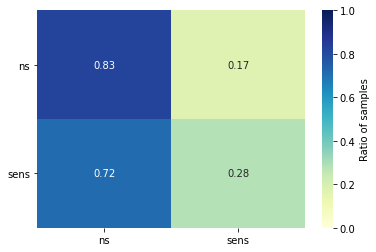

In [ ]:
from utils import plot_confusion_matrix

def get_predictions_df_BERT(predictor, X, Y):
    Y_pred_m = []
    for text in X:
        Y_pred_m.append(predictor.predict(text))
    df_test = pd.DataFrame({'true': Y, 'pred': Y_pred_m})
    #df_test['true'] = df_test['true'].apply(lambda x: np.argmax(x))
    return df_test

df_test_2 = get_predictions_df_BERT(predictor, data_test["text"].tolist(), data_test["class"].tolist())
plot_confusion_matrix(df_test_2, normalize=True, labels=Y_feat_names)


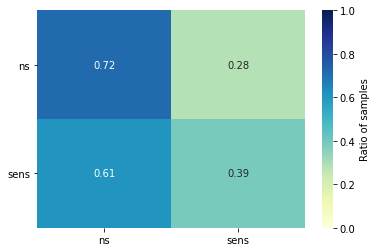

In [ ]:
data_test["text"][:4].tolist()
data_test["class"][:4].tolist()
data_test.dropna()["text"][260:270]
#data_test["text"][265]
#df_test


260    iPhone 3GS 16GB: UK price = £440 USA Price = £...
261    RT @shermy shermy arrrgghhhhh this federer - d...
262                             I hate all my co workers
263    -It was my Freshman year at college. I was in ...
264    So there's no sensible girls to chat with appa...
266    @gsieranski @Footdr69 Thanks guys. Scat is ado...
267                     @DjDNOVA shouts back you you....
268    @romiss86 pero hay varios lugares q tiene sand...
269    Guys,what is the ideal size boobs for a girl??...
270    Wanting a new tattoo, just not sure what to ge...
Name: text, dtype: object

## Step 4: Training (Finetuning the BERT Classifier)

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
1096/1096 [==============================] - 804s 716ms/step - loss: 0.7027 - accuracy: 0.5901
Epoch 2/5
1096/1096 [==============================] - 783s 714ms/step - loss: 0.5032 - accuracy: 0.7581
Epoch 3/5
1096/1096 [==============================] - 784s 715ms/step - loss: 0.6801 - accuracy: 0.6221
Epoch 4/5
1096/1096 [==============================] - 340s 310ms/step - loss: 1.8562 - accuracy: 0.5381


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


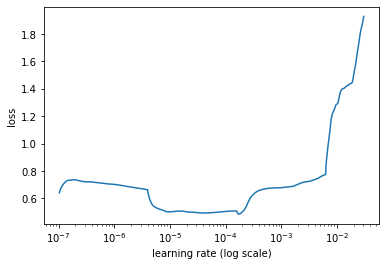

In [ ]:
# simulate training to find good learning rate
learner.lr_find(max_epochs=5)
learner.lr_plot()

# **Agreement on 3 annotators**
## STEP 1: Get train and test sets 

In [ ]:
data = get_data(dataset_path, lim=3)
data = get_two_classes(data)
data = data[['text', 'class']]

print('DataSet:\n', data.head())
print('---------------------------------\n')
print('Dataset: size', len(data), 'Number Sens:', len(data[data['class'] == 'sens']), 'Number No Sens:', len(data[data['class'] == 'ns']))

for idx, row in data.iterrows():
    row[0] = row[0].replace('rt', '')

print('---------------------------------\n')

## create train, validation and test sets
Y_feat_names = pd.get_dummies(data['class']).columns.tolist()
x_train, x_val, x_test, y_train, y_val, y_test = my_train_val_test_split(data['text'].values, data['class'].values, validation_ratio, test_ratio, 512)
print("Size of: training -> "+str(len(x_train))+" ("+str(int(100*len(x_train)/(len(data))))+"%), val -> "+str(len(x_val))+" ("+str(int(100*len(x_val)/(len(data))))+"%), test -> "+str(len(x_test))+" ("+str(int(100*len(x_test)/(len(data))))+"%)")

# transform classes in pairs
y_train = pd.get_dummies(pd.DataFrame({"class": y_train})["class"])[Y_feat_names].values
y_test = pd.get_dummies(pd.DataFrame({"class": y_test})["class"])[Y_feat_names].values
y_val = pd.get_dummies(pd.DataFrame({"class": y_val})["class"])[Y_feat_names].values
print("\nNumber of samples in each class",Y_feat_names, "in: training set ->", y_train.sum(axis=0), "; validation set ->", y_val.sum(axis=0), "; test set ->", y_test.sum(axis=0))


DataSet:
                                                    text class
2817  is sore and wants the knot of muscles at the b...  sens
2818                                        is home. <3  sens
2819  is in Kentucky. 421 miles into her 1100 mile j...  sens
208                   has a crush on the Green Lantern.    ns
209                             has magic on the brain.    ns
---------------------------------

Dataset: size 4046 Number Sens: 1444 Number No Sens: 2602
---------------------------------

Size of: training -> 3036 (75%), val -> 606 (14%), test -> 404 (9%)

Number of samples in each class ['ns', 'sens'] in: training set -> [1952 1084] ; validation set -> [390 216] ; test set -> [260 144]


In [ ]:
x_train[0]

"Once again can't sleep, but too tired to do anything productive."

In [ ]:
y_train[0]

array([0, 1], dtype=uint8)

## STEP 2: Load and Preprocess the Data


In [ ]:
(x_train_bert,  y_train_bert), (x_val_bert, y_val_bert), preproc = text.texts_from_array(x_train=x_train, y_train=y_train,
                                                                                          x_test=x_val, y_test=y_val,
                                                                                          class_names=Y_feat_names,
                                                                                          preprocess_mode='bert',
                                                                                          lang='en',
                                                                                          maxlen=350, 
                                                                                          max_features=35000)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


## STEP 3:  Load the BERT Model and Instantiate a Learner object


In [ ]:
model = text.text_classifier('bert', train_data=(x_train_bert, y_train_bert), preproc=preproc)
learner = ktrain.get_learner(model, train_data=(x_train_bert, y_train_bert), val_data=(x_val_bert, y_val_bert), batch_size=6)


Is Multi-Label? False
maxlen is 350
done.


## Step 4: Training (Finetuning the BERT Classifier)

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
506/506 [==============================] - 372s 708ms/step - loss: 0.7275 - accuracy: 0.6421
Epoch 2/5
506/506 [==============================] - 359s 709ms/step - loss: 0.3733 - accuracy: 0.8452
Epoch 3/5
506/506 [==============================] - 359s 710ms/step - loss: 0.6599 - accuracy: 0.6553
Epoch 4/5
506/506 [==============================] - 92s 180ms/step - loss: 1.6715 - accuracy: 0.5777


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


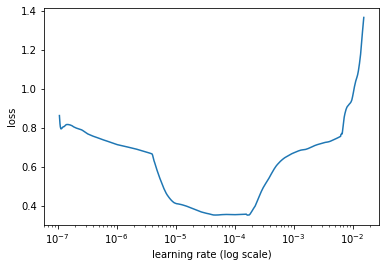

In [ ]:
# simulate training to find good learning rate
learner.lr_find(max_epochs=5)
learner.lr_plot()

## STEP 5: Train the Model


In [ ]:
learner.autofit(5e-5)

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 5e-05...
Epoch 1/1024
506/506 [==============================] - 408s 780ms/step - loss: 0.3692 - accuracy: 0.8439 - val_loss: 0.1970 - val_accuracy: 0.9340
Epoch 2/1024
506/506 [==============================] - 390s 771ms/step - loss: 0.1763 - accuracy: 0.9368 - val_loss: 0.1981 - val_accuracy: 0.9158
Epoch 3/1024
506/506 [==============================] - 390s 771ms/step - loss: 0.0731 - accuracy: 0.9769 - val_loss: 0.2905 - val_accuracy: 0.9175

Epoch 00003: Reducing Max LR on Plateau: new max lr will be 2.5e-05 (if not early_stopping).
Epoch 4/1024
506/506 [==============================] - 390s 772ms/step - loss: 0.0148 - accuracy: 0.9957 - val_loss: 0.3256 - val_accuracy: 0.9224
Epoch 5/1024
506/506 [==============================] - 389s 769ms/step - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.3830 - val

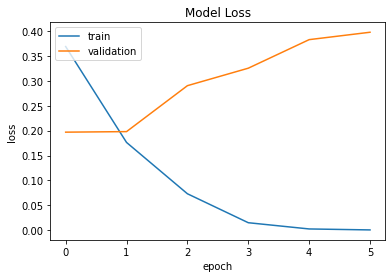

In [ ]:
learner.plot()

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       390
           1       0.92      0.89      0.91       216

    accuracy                           0.93       606
   macro avg       0.93      0.92      0.93       606
weighted avg       0.93      0.93      0.93       606



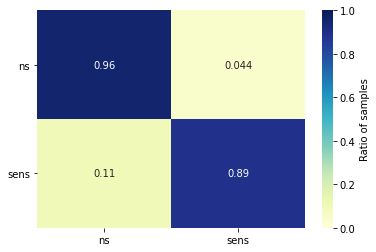

In [ ]:
df_val = learner.evaluate()
plot_confusion_matrix_from_cmat(df_val, normalize=True, labels=Y_feat_names)


## STEP 6: Test the Model


              precision    recall  f1-score   support

          ns       0.91      0.95      0.93       260
        sens       0.90      0.84      0.87       144

    accuracy                           0.91       404
   macro avg       0.91      0.90      0.90       404
weighted avg       0.91      0.91      0.91       404



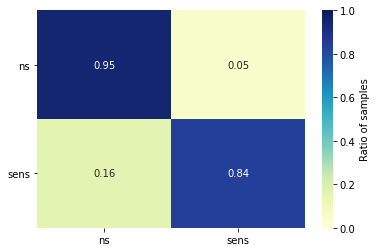

In [ ]:
# validation on test set
x_test_bert = preproc.preprocess(x_test)
df_test = learner.validate(val_data=(x_test_bert, y_test), class_names=Y_feat_names)
plot_confusion_matrix_from_cmat(df_test, normalize=True, labels=Y_feat_names)


In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)
# save
predictor.save(main_path+"results/sensitag_BERT_ann3")


## STEP 7: Use the Model

In [ ]:
# use the trained model on simple sentences
for input_text in ["is happy", "is tired", "is depressed", "is back from Spain", "is in Spain", "loves Spain",
                   "is in Italy", "loves Italy", "is going out", "is out", "works until 6PM", "starts working at 9AM"]:
    predict_class(input_text, predictor, Y_feat_names)


is happy -> ns (ns: 0.9539539 sens: 0.046046067)
is tired -> ns (ns: 0.8979013 sens: 0.10209872)
is depressed -> sens (ns: 0.12653637 sens: 0.8734637)
is back from Spain -> sens (ns: 0.09747401 sens: 0.90252596)
is in Spain -> sens (ns: 0.118933335 sens: 0.8810666)
loves Spain -> ns (ns: 0.7620372 sens: 0.23796277)
is in Italy -> sens (ns: 0.011443282 sens: 0.98855674)
loves Italy -> sens (ns: 0.25063306 sens: 0.7493669)
is going out -> sens (ns: 0.023815038 sens: 0.9761849)
is out -> ns (ns: 0.88380754 sens: 0.116192475)
works until 6PM -> sens (ns: 0.046387512 sens: 0.9536125)
starts working at 9AM -> sens (ns: 0.015681185 sens: 0.9843188)


In [ ]:
# use the trained model on few sentences in the test set
for index, input_text in enumerate(x_test[:10]):
    real_class = [y for x,y in zip(y_test[index],Y_feat_names) if x==1][0]
    predict_class(input_text, predictor, Y_feat_names, real_class=real_class)

I LOVE SNOW!!! -> ns (V) (ns: 0.98867387 sens: 0.011326146)[ns]
I'm sooo lucky to have such good friends and family! Thanks for all the sweet bday messages! Lots of love to you all! -> ns (V) (ns: 0.8428704 sens: 0.15712959)[ns]
Strawberries make everything better :) -> ns (V) (ns: 0.98980284 sens: 0.01019717)[ns]
Feels aweful right now. Why do you get sick like this on weekends only... I better not have to use a sick day tomorrow or I will be pissed. -> sens (V) (ns: 0.06278663 sens: 0.93721336)[sens]
Anyways back to DR... -> ns (V) (ns: 0.87602997 sens: 0.123970024)[ns]
i want to carve a pumpkin! -> ns (V) (ns: 0.9892057 sens: 0.010794329)[ns]
Yuppie (sho for "young urban professional" or "young upwardly-mobile professional") [1] is a 1980s and early 1990s term for financially secure, upper-middle class young people in their 20s and early 30s.  [2]. Although its first usage was as a media catchphrase, it eventually became somewhat derogatory in nature. -> ns (V) (ns: 0.9905787 sens: 

In [ ]:
# try the explaination tool of the trained model on a sentence in the test set
test_index = 1
print(x_test[test_index])
print(Y_feat_names, y_test[test_index])
predictor.explain(x_test[test_index])

I'm sooo lucky to have such good friends and family! Thanks for all the sweet bday messages! Lots of love to you all!
['ns', 'sens'] [1 0]


In [ ]:
# get the set of uncertain sentences
data_uncertain = get_data(dataset_path, lim=2)
data_uncertain = data_uncertain[data_uncertain["class"] == "Non so"]["text"].values
len(data_uncertain)

190

In [ ]:
# use the trained model on few sentences in the set of uncertain sentences
for input_text in data_uncertain[:20]:
    predict_class(input_text, predictor, Y_feat_names)


www.thejokerblogs.com -> ns (ns: 0.9943469 sens: 0.005653058)
is in love with *PROPNAME*. -> sens (ns: 0.06547794 sens: 0.93452203)
is in love. With *PROPNAME*. -> sens (ns: 0.048246436 sens: 0.9517535)
is dying!!! HEEEEELPPPPP!!!!! -> sens (ns: 0.35075843 sens: 0.64924157)
WOW!!! I just spent 20 minutes reading just this one strip... [link] -> ns (ns: 0.9876823 sens: 0.012317673)
acquired 6 brothers and sisters today... -> sens (ns: 0.26631966 sens: 0.7336803)
is trying to fight it off -> ns (ns: 0.92517084 sens: 0.0748292)
is still patiently waiting for 9 -> ns (ns: 0.962825 sens: 0.037174996)
HOLY. FUCK. [link] -> ns (ns: 0.9625972 sens: 0.03740287)
thanks everyone, but i decided to get younger this year... :) -> ns (ns: 0.6395323 sens: 0.36046767)
bar... -> ns (ns: 0.7477952 sens: 0.25220484)
thinks it's funny that only his white best friend remembered *PROPNAME*. -> sens (ns: 0.4400935 sens: 0.55990654)
has heard *PROPNAME*'s tragic call to keep my shit together and live life prop

## STEP 8: Load and reuse the Model


In [ ]:
# reload the predictor
# reloaded_predictor = ktrain.load_predictor("/content/drive/MyDrive/Colab Notebooks/results/sensitag_predictor")
# make a prediction on the same document to verify it still works
# reloaded_predictor.predict(x_test[0])


# Test models on whispers


In [ ]:
from utils import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

def get_predictions_df_BERT(predictor, X, Y):
    Y_pred_m = []
    for text in X:
        Y_pred_m.append(predictor.predict(text))
    df_test = pd.DataFrame({'true': Y, 'pred': Y_pred_m})
    #df_test['true'] = df_test['true'].apply(lambda x: np.argmax(x))
    return df_test

def print_pre_met(df_test, Y_feat_names):
    prec = precision_score(df_test["true"].tolist(), df_test["pred"].tolist(), average=None)
    rec = recall_score(df_test["true"].tolist(), df_test["pred"].tolist(), average=None)
    f1 = f1_score(df_test["true"].tolist(), df_test["pred"].tolist(), average=None)
    f1_macro = f1_score(df_test["true"].tolist(), df_test["pred"].tolist(), average="macro")
    f1_micro = f1_score(df_test["true"].tolist(), df_test["pred"].tolist(), average="micro")
    print("\tprecision    recall  f1-score\n")
    for i in range(2):
    #    print(Y_feat_names[i]+"\t     "+str(round(prec[i],2))+"\t  "+str(round(rec[i],2))+"\t    "+str(round(f1[i],2)))
        print(Y_feat_names[i]+"\t"+str("{:9.2f}".format(prec[i]))+str("{:10.2f}".format(rec[i]))+str("{:10.2f}".format(f1[i])))
    print("\nf1-macro\t"+str("{:21.2f}".format(f1_macro)))
    print("f1-micro\t"+str("{:21.2f}".format(f1_micro)))
    return

data_test = pd.read_csv(main_path+"data/sample_ann2_01.csv").dropna()
print('DataSet:\n', data_test.head())


DataSet:
                                                 text class
0  Column's all done for another week. Shaheen Ja...    ns
1  OMG i'm going to pass out and i've been left a...    ns
2  blown through so many red lights mind not on s...  sens
3           Walking up to the library. I smell rain.    ns
4  Erica Jong’s 20 Rules for Writers http://ow.ly...    ns


## 2 Annotators

In [ ]:
# reload the predictor
predictor = ktrain.load_predictor("/content/drive/MyDrive/Colab Notebooks/results/sensitag_BERT_ann2")
# make a prediction on the same document to verify it still works
# predictor.predict(x_test[0])


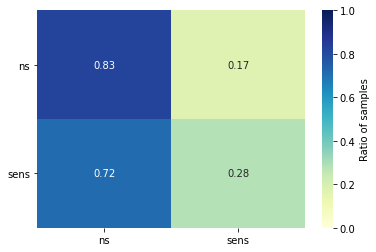

In [ ]:
df_test_2 = get_predictions_df_BERT(predictor, data_test["text"].tolist(), data_test["class"].tolist())
plot_confusion_matrix(df_test_2, normalize=True, labels=Y_feat_names)


In [ ]:
print_pre_met(df_test_2, Y_feat_names)

	precision    recall  f1-score

ns	     0.65      0.83      0.73
sens	     0.50      0.28      0.36

f1-macro	                 0.55
f1-micro	                 0.62


## 3 Annotators

In [ ]:
# reload the predictor
predictor = ktrain.load_predictor("/content/drive/MyDrive/Colab Notebooks/results/sensitag_BERT_ann3")

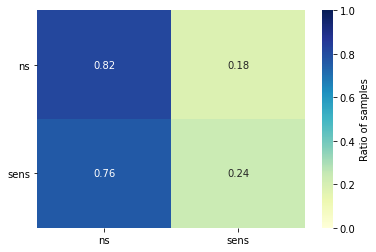

In [ ]:
df_test_2 = get_predictions_df_BERT(predictor, data_test["text"].tolist(), data_test["class"].tolist())
plot_confusion_matrix(df_test_2, normalize=True, labels=Y_feat_names)


In [ ]:
print_pre_met(df_test_2, Y_feat_names)

	precision    recall  f1-score

ns	     0.64      0.82      0.72
sens	     0.45      0.24      0.31

f1-macro	                 0.51
f1-micro	                 0.60
